# OTE-01: Initial Image Mosaic

Steps:
- Perturb the primary and secondary mirrors to reflect expectations for initial deployment
- Record the tilt of each PM and remove the piston/tip/tilt
- Generate segment PSFs
- ... figure out how to turn those PSFS into MIRAGE simulations

> Email from Marshall:
- Create 18 independent segment PSFs centered on each segment, each with some suitably small size rather than gigantic: 
    - Apply random perturbations as you are doing. 
    - For each segment, cut out just that segment from the OPD map (using the one_segment_pupil helper function in WebbPSF).
    - This part’s somewhat tricky. For each segment we will want to record what the tip/tilt  is, then zero it out before creating the PSF (so that we get the PSF centered on where the segment is). We can use the tip/tilt values in the OPD to compute the equivalent vector to where that PSF would be. 
    - End result should be 18 separate PSF arrays, plus for each one a tip/tilt vector saying where that should appear relative to the center of the PSF array.
- Iterate over the list of targets in MIRAGE
- For each target, iterate over the list of 18 PSFs and their offsets. 
- Compute the apparent location of that PSF as the sum of the coordinates that star would normally have in the field of view plus the offset to that PSF.
- If that PSF falls inside the detector field of view somewhere, put it there. Otherwise, skip that PSF. 

In [22]:
# Standard Library Imports
import os
import re
import sys
import time
import multiprocessing

# Third Party Imports
import pprint
from glob import glob
import numpy as np
import webbpsf
from astropy.io import fits
from astropy.io import ascii as asc
import matplotlib.pyplot as plt

# Local Imports (from nircam_simulator package)
from mirage import imaging_simulator
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator
from mirage.apt import apt_inputs
from mirage.yaml import yaml_generator, write_observationlist
from mirage.catalogs import get_catalog
from mirage.psf import psf_library

# View matplotlib plots inline
%matplotlib inline

### Define location of input and output files

In [23]:
# Where the pointing and XML file for this particular OTE CAR are located
ote_dir = '/user/lchambers/OTECommSims/OTE01_reducedmosaic/'

# Where the output FITS files will be saved to
library_root_dir = '/user/lchambers/OTECommSims/OTE01_library/'

In [24]:
prop_id = 1134

# Change if you named your files differently.
root = 'OTE01-{}-reduced_mosaic'.format(prop_id)

pointing_file = os.path.join(ote_dir, '{}.pointing'.format(root))
xml_file = os.path.join(ote_dir, '{}.xml'.format(root))

---
# First, simulate the OTE state

In [25]:
sys.path.insert(0,'../Initial_Deployment/')
import deployments

In [26]:
nc = webbpsf.NIRCam()
nc.filter = 'F212N'
nc, ote = webbpsf.enable_adjustable_ote(nc)

deployment_errors = deployments.get_deployment_errors(reduction_factor=0.2)
ote, segment_tilts = deployments.apply_deployment_errors(ote, deployment_errors)
ote = deployments.remove_piston_tip_tilt(ote)

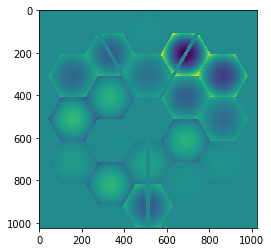

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000     4.1406   -22.0435    -4.3870
A2	     0.0000     0.0000     0.0000   -21.0804   -13.1962    -7.7083
A3	     0.0000     0.0000     0.0000    80.1468   -42.8895     8.2917
A4	     0.0000     0.0000     0.0000    39.9107   -47.2723     4.6417
A5	     0.0000     0.0000     0.0000    38.5367  -115.0167    -7.7945
A6	     0.0000     0.0000     0.0000    20.7416    35.1439    -0.3309
B1	     0.0000     0.0000     0.0000   -69.0291    37.1262     8.7817
C1	     0.0000     0.0000     0.0000    57.3217   -23.5220    -1.2316
B2	     0.0000     0.0000     0.0000    66.6243    30.0477    -1.7280
C2	     0.0000     0.0000     0.0000   -45.2284   -60.9999     5.9957
B3	     0.0000     0.0000     0.0000   -15.8384    14.0872    14.5439
C3	     0.0000     0.0000     0.0000   -62.6328   -3

In [27]:
plt.imshow(ote.opd)
plt.show()
ote.print_state()
print(segment_tilts)

---
# Second, generate PSF library files

In [45]:
# Generate and save 18 segment PSFs
for i in range (18):
    # Restrict the pupil to the current segment
    i_segment = i + 1
    pupil = webbpsf.webbpsf_core.one_segment_pupil(i_segment)
    ote.amplitude = pupil[0].data
    
    # Add header keywords about segment
    hdr = fits.Header()
    hdr['SEGID'] = (i_segment, 'ID of the mirror segment')
    hdr['XTILT'] = (round(segment_tilts[i, 0], 2), 'X tilt of the segment in microns')
    hdr['YTILT'] = (round(segment_tilts[i, 1], 2), 'Y tilt of the segment in microns')
    
    fov_pixels = 1024
    library_filename = 'nircam_f200w_fovp{}_samp1_npsf1_seg{}.fits'.format(fov_pixels, i_segment)
    c = psf_library.CreatePSFLibrary('NIRCam', filters='F212N', detectors='NRCA3', 
                                     fov_pixels=fov_pixels, oversample=1, num_psfs=1, 
                                     fileloc=library_root_dir, filename=library_filename,
                                     pupil_opd=ote, overwrite=False, header_addons=hdr)
    c.create_files()
    
    print('Completed segment {}'.format(i + 1))


Starting filter: F212N
  Running detector NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f200w_fovp1024_samp1_npsf1_seg1.fits
Completed segment 1

Starting filter: F212N
  Running detector NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f200w_fovp1024_samp1_npsf1_seg2.fits
Completed segment 2

Starting filter: F212N
  Running detector NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f200w_fovp1024_samp1_npsf1_seg3.fits
Completed segment 3

Starting filter: F212N
  Running detector NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f200w_fovp1024_samp1_npsf1_seg4.fits
Completed segment 4

Starting filter: F212N
  Running detector NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f200w_fovp1024_samp1_npsf1_seg5.fits
Completed segment 5

Starting filter: F212N
  Running detector NRCA3
  Saving file: /user/lchambers/OTECommSims/OTE01_library/nircam_f200w_fovp1024_samp1_npsf1_seg6.fits


---
# Third, create `.yaml` files for each exposure

### Get the source catalogs

In [ ]:
# Get SW and LW catalogs
cats = get_catalog.get_all_catalogs(pointing_file, prop_id)
target_coords, catalog_filenames_sw, catalog_filenames_lw = cats

In [ ]:
# Create observation table file from APT files
observationlist_file = os.path.join(os.getcwd(), ote_dir, root + '_observationlist.yaml')
write_observationlist.write_yaml(xml_file, pointing_file, observationlist_file, 
                                 ps_cat_sw=catalog_filenames_sw, ps_cat_lw=catalog_filenames_lw)

In [ ]:
# Create a series of data simulator input yaml files from APT files
yam = yaml_generator.SimInput()

yam.input_xml = xml_file
yam.pointing_file = pointing_file
siaf_file = os.path.expandvars('$MIRAGE_DATA/nircam/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv')
yam.siaf = siaf_file
yam.output_dir = ote_dir #os.path.join(os.getcwd(), ote_dir)
yam.simdata_output_dir = ote_dir #os.path.join(os.getcwd(), ote_dir)
yam.observation_table = observationlist_file

# *** THIS IS THE PART WHERE WE MODIFY THE PSF ***
yam.psf_paths = library_root_dir

yam.use_JWST_pipeline = False # changed to False
yam.use_linearized_darks = True # changed to True
yam.datatype = 'linear'

yam.reffile_setup()
yam.create_inputs()

In [ ]:
# Print information about the yaml files that were generated.
yfiles = glob(os.path.join(ote_dir, 'jw*yaml'))

obs_numbers = [f.split('/')[-1].split('_')[0] for f in yfiles]
all_obs_numbers = list(set(obs_numbers))
all_obs_numbers.sort()

n_obs = len(set([int(number[9:11]) for number in all_obs_numbers]))

print('Found {} yaml files.'.format(len(obs_numbers)))
print('({} exposures across {} observations)'.format(len(all_obs_numbers), n_obs))
# pprint.pprint(all_obs_numbers)

In [ ]:
# Get list of YAML files for observation 1 (all 10 detectors)
obs1_visit1_files = glob(os.path.join(ote_dir, 'jw01134001*yaml'))
print('{} yaml files found in program APT 1134 Observation 1'.format(len(obs1_visit1_files)))

In [ ]:
with fits.open(obs1_fits_files[0]) as hdu:
    hdu.info()

In [ ]:
# Generate "mosaic" from images
obs1_fits_files = glob('/user/lchambers/OTECommSims/OTE01_reducedmosaic/jw*linear.fits')

for f in sorted(obs1_fits_files):
    print(f.split('/')[-1])
    with fits.open(f) as hdu:
        print(hdu[0].header['TARG_RA'])
        print(hdu[0].header['RA_V1'])
        print(hdu[0].header['XOFFSET'], hdu[0].header['YOFFSET'])
        print()

---
# Latest version of script:
```python
import datetime

from astropy.io import fits
import webbpsf
import numpy as np

# Generate a PSF with a perturbed OTE according to the expected deployment tolerances.
# Deployment tolerances taken from JWST WFS&C Commissioning and Operations Plan (OTE-24):
# D36168 / 2299462 Rev C Page 10

nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

# 1. Generate the OPD
# ------------------------------------------------------------------------------

# *** QUESTION: Do I want to pull these random values from a normal distribution? ***


# Add SM moves
random_sm_piston = np.random.random(1) * 5000 - 2500  # microns
random_sm_tilt = np.random.random(2) * 2600 - 1300  # microradians
random_sm_decenter = np.random.random(2) * 5000 - 2500  # microns

ote.move_sm_local(piston=random_sm_piston, xtilt=random_sm_tilt[0],
                  ytilt=random_sm_tilt[1], xtrans=random_sm_decenter[0],
                  ytrans=random_sm_decenter[1])

# Add PMSA (segment) moves
random_pm_piston = np.random.random(18) * 3000 - 1500  # microns
random_pm_tilt = np.random.random((18, 2)) * 2200 - 1100  # microradians
random_pm_decenter = np.random.random((18, 2)) * 2600 - 1300  # microns
random_pm_roc = np.random.random(18) * 302 - 151  # microns
random_pm_clocking = np.random.random(18) * 2400 - 1200  # microradians

global_pm_piston = np.random.random(1) * 1400 - 700  # microns
global_pm_tilt = np.random.random(2) * 380 - 190  # microradians
global_pm_decenter = np.random.random(2) * 400 - 200  # microns
global_pm_clocking = np.random.random(1) * 300 - 150  # microradians

for i, seg in enumerate(ote.segnames[0:18]):
    ote.move_seg_local(seg,
                       piston=random_pm_piston[i] + global_pm_piston,
                       xtilt=random_pm_tilt[i][0] + global_pm_tilt[0],
                       ytilt=random_pm_tilt[i][1] + global_pm_tilt[1],
                       xtrans=random_pm_decenter[i][0] + global_pm_decenter[0],
                       ytrans=random_pm_decenter[i][1] + global_pm_decenter[1],
                       roc=random_pm_roc[i],
                       clocking=random_pm_clocking[i] + global_pm_clocking)

# Save the OPD as a fits file
now = datetime.datetime.now()
ote_filename = "{:2d}{:2d}{:2d}-{:2d}{:2d}{:2d}-OTE01_perturbedOTE.fits".format(
    now.year, now.month, now.day, now.hour, now.minute, now.second
)
hdulist = fits.HDUList(hdus=ote.as_fits())
hdulist.writeto(ote_filename, output_verify='ignore')
print('Save perturbed OTE to {}'.format(ote_filename))

# 2. Generate the PSF for entire OTE pupil
# ------------------------------------------------------------------------------

# Calculate the PSF over 10 x 10 NIRCam fields of view (oy vey)
# Simulating the "Central" observation from APT Program 1134
now = datetime.datetime.now()
psf_filename = "{:2d}{:2d}{:2d}-{:2d}{:2d}{:2d}-OTE01_PSF.fits".format(
    now.year, now.month, now.day, now.hour, now.minute, now.second
)
fov_pixels = 2048 * 10
nc.calc_psf(nlambda=30, oversample=1, fov_pixels=fov_pixels, add_distortion=False,
            outfile=psf_filename)
print('Done generating the PSF!! Oh my goodness!!!')

# 3. Generate the PSF for a single segment pupil... 18 times
# ------------------------------------------------------------------------------

# Then, once all that is done, generate the same thing... for all 18 segments.
# Oy vey x 18
for i_segment in np.arange(1, 19):
    # Restrict the pupil to just be one segment
    pupil = webbpsf.webbpsf_core.one_segment_pupil(i_segment)
    ote.amplitude = pupil[0].data

    # Calculate the PSF over 10 x 10 NIRCam fields of view (oy vey)
    # Simulating the "Central" observation from APT Program 1134
    now = datetime.datetime.now()
    psf_filename = "{:2d}{:2d}{:2d}-{:2d}{:2d}{:2d}-OTE01_segment{}_PSF.fits".format(
        now.year, now.month, now.day, now.hour, now.minute, now.second, i_segment
    )
    fov_pixels = 2048 * 10
    nc.calc_psf(nlambda=30, oversample=1, fov_pixels=fov_pixels, add_distortion=False,
                outfile=psf_filename)
    print('Done generating the PSF for the {}th segment!! Truly a miracle.'.format(i_segment))

print('You will never get here, but I finished. Tada!')
```